In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predictive-maintenance-dataset-ai4i-2020/ai4i2020.csv


In [2]:
df = pd.read_csv("/kaggle/input/predictive-maintenance-dataset-ai4i-2020/ai4i2020.csv")
df.columns = df.columns.str.replace('[', '(').str.replace(']', ')') # had some issues with [] during model training

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature (K)      10000 non-null  float64
 4   Process temperature (K)  10000 non-null  float64
 5   Rotational speed (rpm)   10000 non-null  int64  
 6   Torque (Nm)              10000 non-null  float64
 7   Tool wear (min)          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

### Data Processing

In [4]:
def process_data(df):
    # replace L, M, H with 0, 1, 2 so it is numeric
    df['Type'] = df['Type'].replace(['L', 'M', 'H'], [0, 1, 2])

    # replacing machine failure column with the 5 kinds of machine failures
    df.loc[(df['Machine failure'] == 1) & (df['TWF'] == 1), 'Machine failure'] = 1
    df.loc[(df['Machine failure'] == 1) & (df['HDF'] == 1), 'Machine failure'] = 2
    df.loc[(df['Machine failure'] == 1) & (df['PWF'] == 1), 'Machine failure'] = 3
    df.loc[(df['Machine failure'] == 1) & (df['OSF'] == 1), 'Machine failure'] = 4
    df.loc[(df['Machine failure'] == 1) & (df['RNF'] == 1), 'Machine failure'] = 5

    # removing the old TWF, HDF, etc. columns as they are already accounted for
    df.drop(columns = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF'], inplace=True)

    # dropping the Product ID and UDI columnns as they are not necessary in model training
    df.drop(columns = ['UDI', 'Product ID'], inplace=True)
process_data(df)

/tmp/ipykernel_18/53244720.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Type'] = df['Type'].replace(['L', 'M', 'H'], [0, 1, 2])


### EDA

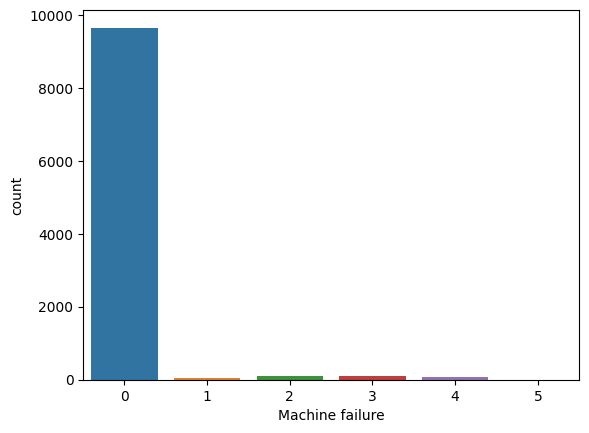

In [5]:
sns.countplot(x='Machine failure', data=df);

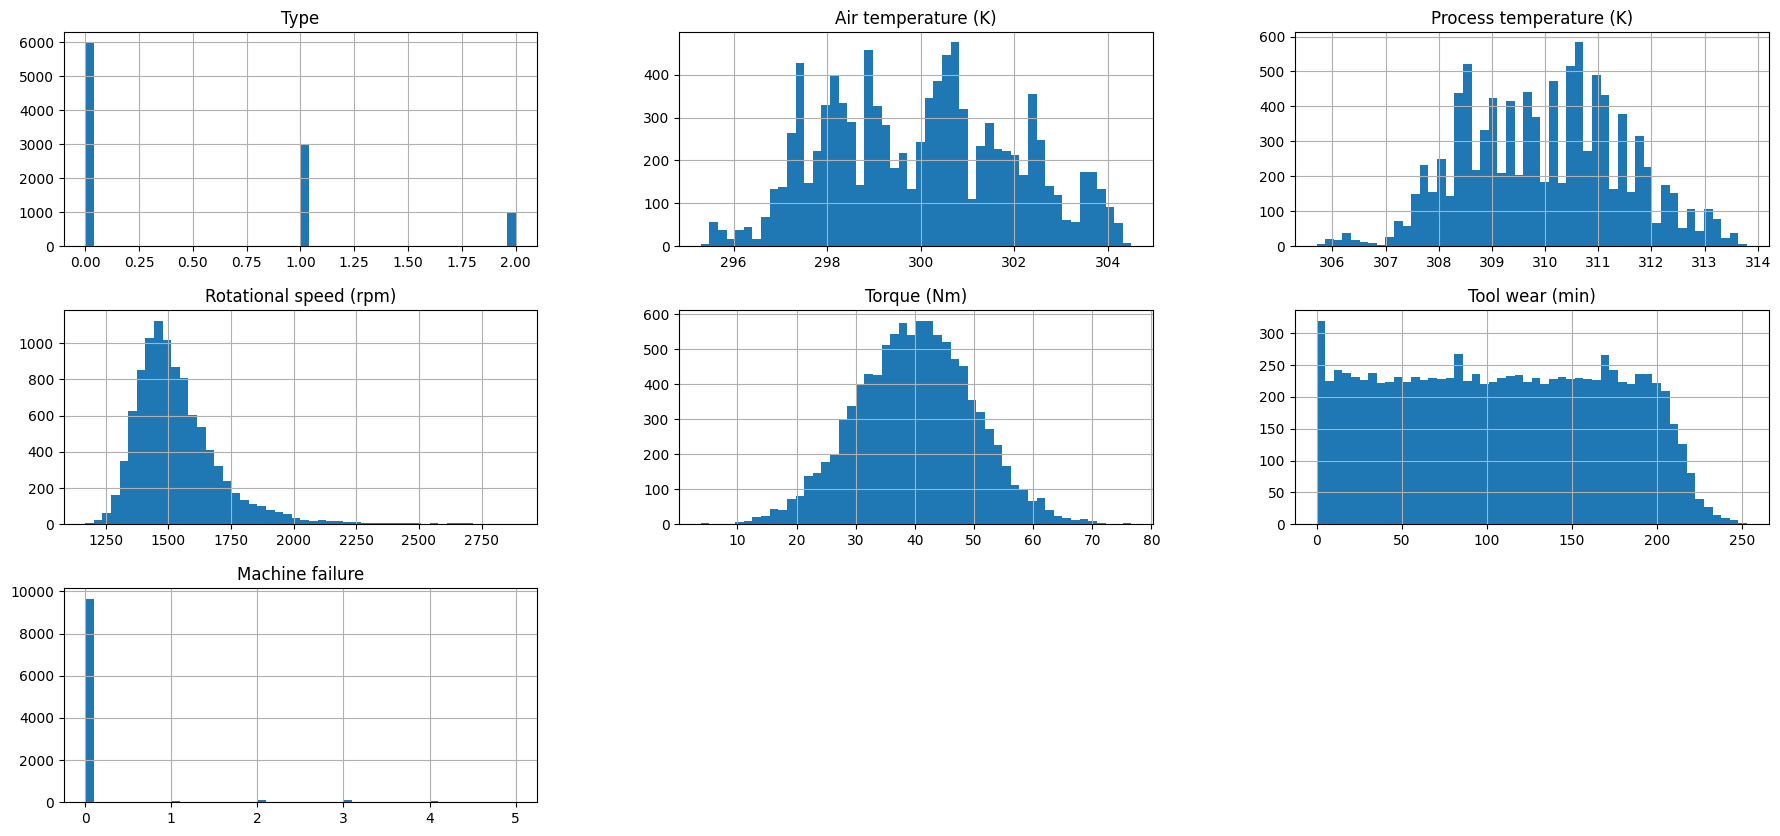

In [6]:
df.hist(figsize = (22,10), bins = 50)
plt.show()

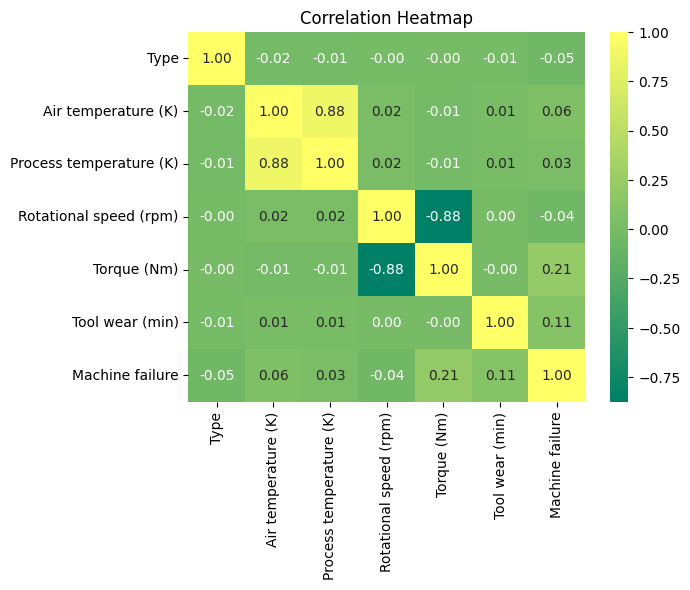

In [7]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='summer', fmt=".2f")
plt.title('Correlation Heatmap');

In [8]:
df.describe()

,Type,Air temperature (K),Process temperature (K),Rotational speed (rpm),Torque (Nm),Tool wear (min),Machine failure
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.500300,300.004930,310.005560,1538.776100,39.986910,107.951000,0.088200
std,0.671301,2.000259,1.483734,179.284096,9.968934,63.654147,0.506603
min,0.000000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,0.000000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,0.000000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,1.000000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,2.000000,304.500000,313.800000,2886.000000,76.600000,253.000000,5.000000


### Model Training

In [9]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

classification_models = {
    "RandomForestClassifier": RandomForestClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "XGBClassifier": XGBClassifier()
}

hyperparameter_grids = {
    "RandomForestClassifier": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    },

    "GradientBoostingClassifier": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },

    "KNeighborsClassifier": {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },

    "AdaBoostClassifier": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'algorithm': ['SAMME', 'SAMME.R']
    },

    "XGBClassifier": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0]
    }
}

In [10]:
X = df.drop("Machine failure", axis=1)
y = df['Machine failure']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=10)

In [11]:
%%time
best_params_grids = {}
np.random.seed(10)
# searching through all possible variations of the hyperparameters for each model to find the best one
for model_name, params in hyperparameter_grids.items():
  gs_model = GridSearchCV(classification_models[model_name],
                          param_grid=params,
                          scoring='accuracy',
                          n_jobs=-1)
  gs_model.fit(X_train, y_train)
  best_params_grids[model_name] = gs_model.best_params_

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


CPU times: user 58 s, sys: 11 s, total: 1min 8s
Wall time: 1h 14min 30s


In [12]:
best_params_grids

{'RandomForestClassifier': {'max_depth': 20,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 50},
 'GradientBoostingClassifier': {'learning_rate': 0.1,
  'max_depth': 7,
  'min_samples_leaf': 2,
  'min_samples_split': 2,
  'n_estimators': 200},
 'KNeighborsClassifier': {'n_neighbors': 7, 'p': 1, 'weights': 'distance'},
 'AdaBoostClassifier': {'algorithm': 'SAMME.R',
  'learning_rate': 0.1,
  'n_estimators': 100},
 'XGBClassifier': {'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 200,
  'subsample': 1.0}}

In [13]:
tuned_classification_models = {
    "RandomForestClassifier": RandomForestClassifier(**best_params_grids['RandomForestClassifier']),
    "GradientBoostingClassifier": GradientBoostingClassifier(**best_params_grids['GradientBoostingClassifier']),
    "KNeighborsClassifier": KNeighborsClassifier(**best_params_grids['KNeighborsClassifier']),
    "AdaBoostClassifier": AdaBoostClassifier(**best_params_grids['AdaBoostClassifier']),
    "XGBClassifier": XGBClassifier(**best_params_grids['XGBClassifier'])
}

In [14]:
%%time

# where the results will be stored
classification_results = {}
cross_val_results = {}

np.random.seed(10)
# Loop through the items in the tuned_regression_models dictionary
for model_name, model in tuned_classification_models.items():

    # Fit the model to the training data
    print(f"Fitting {model_name}...")
    model.fit(X_train, y_train)

    kf = KFold(n_splits=10)

    # Score the model on the test data appending the model_name to the results dictionary using mean squared error (competition metric) and cross validation
    print(f"Scoring {model_name}...")
    cross_val_results[model_name] = -cross_val_score(model,
                                                     X_test,
                                                     y_test,
                                                     cv=kf)

Fitting RandomForestClassifier...
Scoring RandomForestClassifier...
Fitting GradientBoostingClassifier...
Scoring GradientBoostingClassifier...
Fitting KNeighborsClassifier...
Scoring KNeighborsClassifier...
Fitting AdaBoostClassifier...
Scoring AdaBoostClassifier...
Fitting XGBClassifier...
Scoring XGBClassifier...
CPU times: user 1min 44s, sys: 528 ms, total: 1min 44s
Wall time: 1min 29s


In [15]:
cross_val_results

{'RandomForestClassifier': array([-0.975, -0.98 , -0.955, -0.99 , -0.97 , -0.955, -0.985, -0.97 ,
        -0.995, -0.975]),
 'GradientBoostingClassifier': array([-0.975, -0.99 , -0.975, -0.995, -0.98 , -0.965, -0.99 , -0.975,
        -1.   , -0.98 ]),
 'KNeighborsClassifier': array([-0.975, -0.98 , -0.94 , -0.97 , -0.965, -0.945, -0.99 , -0.97 ,
        -0.995, -0.97 ]),
 'AdaBoostClassifier': array([-0.975, -0.98 , -0.95 , -0.955, -0.965, -0.945, -0.985, -0.97 ,
        -0.995, -0.96 ]),
 'XGBClassifier': array([-0.98 , -0.99 , -0.965, -0.99 , -0.975, -0.96 , -0.985, -0.965,
        -0.995, -0.985])}

In [16]:
cross_val_results = {key: abs(value) for key, value in cross_val_results.items()} # turning values positive
mean_results = {}
std_results = {}
for model, array in cross_val_results.items():
  mean_results[model] = np.mean(array)
  std_results[model] = np.std(array)
  print("mean of " + model + " is " + str(np.mean(array)))
  print("standard deviation of " + model + " is " + str(np.std(array)))
  print("--------------------------")

mean of RandomForestClassifier is 0.9749999999999999
standard deviation of RandomForestClassifier is 0.012649110640673528
--------------------------
mean of GradientBoostingClassifier is 0.9824999999999999
standard deviation of GradientBoostingClassifier is 0.010307764064044161
--------------------------
mean of KNeighborsClassifier is 0.9700000000000001
standard deviation of KNeighborsClassifier is 0.016431676725154998
--------------------------
mean of AdaBoostClassifier is 0.968
standard deviation of AdaBoostClassifier is 0.015198684153570678
--------------------------
mean of XGBClassifier is 0.9789999999999999
standard deviation of XGBClassifier is 0.011575836902790236
--------------------------


In [17]:
mean_results

{'RandomForestClassifier': 0.9749999999999999,
 'GradientBoostingClassifier': 0.9824999999999999,
 'KNeighborsClassifier': 0.9700000000000001,
 'AdaBoostClassifier': 0.968,
 'XGBClassifier': 0.9789999999999999}

In [18]:
std_results

{'RandomForestClassifier': 0.012649110640673528,
 'GradientBoostingClassifier': 0.010307764064044161,
 'KNeighborsClassifier': 0.016431676725154998,
 'AdaBoostClassifier': 0.015198684153570678,
 'XGBClassifier': 0.011575836902790236}

In [19]:
best_mean_model_name = max(mean_results, key=mean_results.get)
best_std_model_name = min(std_results, key=std_results.get)

if best_mean_model_name == best_std_model_name:
    print("Model has both the highest mean and lowest standard deviation.")
else:
    print("Model does not have both the highest mean and lowest standard deviation.")

best_model = tuned_classification_models[best_mean_model_name]
best_model

Model has both the highest mean and lowest standard deviation.


GradientBoostingClassifier(max_depth=7, min_samples_leaf=2, n_estimators=200)

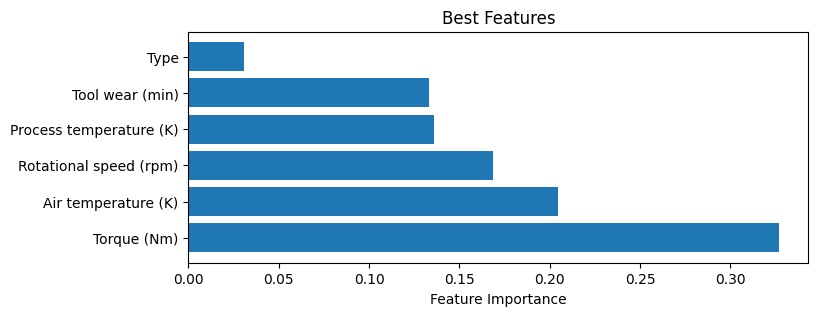

In [20]:
feature_importances = best_model.feature_importances_
feature_names = X.columns

fig, ax = plt.subplots(figsize=(8, len(feature_names) * 0.5))

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = feature_names[sorted_indices]
sorted_numbers = feature_importances[sorted_indices]

ax.barh(range(len(sorted_feature_names)), sorted_numbers)
ax.set_yticks(range(len(sorted_feature_names)))
ax.set_yticklabels(sorted_feature_names)
ax.set_xlabel('Feature Importance')
ax.set_title('Best Features')

plt.show()